## Evaluate the magic wand model
In this notebokk we read the magic wand tflite micro model and take gesture examples for each of the digits to invoke the model.  
Copyright (c) U. Raich  
This program is part of the TinyML course at the University of Cape Coast, Ghana
It is released under the MIT license

In [1]:
import os,sys
import matplotlib.pyplot as plt
import numpy as np
from ai_edge_litert.interpreter import Interpreter
import tensorflow as tf

2025-12-19 16:43:32.503504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Python version: ",sys.version)
print("Tensorflow version: ",tf.__version__)

Python version:  3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]
Tensorflow version:  2.20.0


Create a tflite interpreter from the magic wand model

In [3]:
magic_wand_model = Interpreter(model_path="../models/magic_wand_model_quant.tflite")
magic_wand_model.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
# Get the input and output tensors so we can feed in values and get the results
magic_wand_model_input = magic_wand_model.tensor(magic_wand_model.get_input_details()[0]["index"])
magic_wand_model_output = magic_wand_model.tensor(magic_wand_model.get_output_details()[0]["index"])

Now, that we have the interpreter, let's have a look at the input and output details as well as the quantization

In [5]:
input_details = magic_wand_model.get_input_details()
print(input_details)
print(type(input_details))
input_quantization = (input_details[0]['quantization'])
input_quantization_factor = input_quantization[0]
input_quantization_zero_point = input_quantization[1]
print("Input quantization factor: ",input_quantization_factor, " zero point: ",input_quantization_zero_point)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32, 32,  3], dtype=int32), 'shape_signature': array([-1, 32, 32,  3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, -128), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
<class 'list'>
Input quantization factor:  1.0  zero point:  -128


This means that we must input an array of shape (1,32,32,3) of int8_t values

In [6]:
output_details = magic_wand_model.get_output_details()
print(output_details)
output_quantization = (output_details[0]['quantization'])
output_quantization_factor = output_quantization[0]
output_quantization_zero_point = output_quantization[1]
print("Output quantization factor: ",output_quantization_factor, " zero point: ",output_quantization_zero_point)

[{'name': 'StatefulPartitionedCall:0', 'index': 15, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output quantization factor:  0.00390625  zero point:  -128


## Looking at the test data
We have binary test data which correspond to 32x32 rgb pixel values.  
In the following code we read these test data and plot them

In [7]:
test_data_dir = "../test_data"

read all binary digit files

In [8]:
test_data = []
for i in range(10):
    filename = test_data_dir + "/{:d}.bin".format(i)
    print(filename)
    test_data_file = open(filename,"rb")
    test_data.append(test_data_file.read())
    test_data_file.close()

../test_data/0.bin
../test_data/1.bin
../test_data/2.bin
../test_data/3.bin
../test_data/4.bin
../test_data/5.bin
../test_data/6.bin
../test_data/7.bin
../test_data/8.bin
../test_data/9.bin


In [9]:
print("Length of a test digit file: ",len(test_data[0]),", 32*32*3=",32*32*3)
print("Type of data: ",type(test_data[0]))

Length of a test digit file:  3072 , 32*32*3= 3072
Type of data:  <class 'bytes'>


In [10]:
print(test_data[0][:3*8])

b'\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80'


We have a byte array, which must be transformed into a 32 * 32 * 3 numpy array

In [19]:
digit_0_pixels = np.frombuffer(test_data[0],dtype=np.int8).reshape(32,32,3)

In [20]:
print("Type of digit_0_pixels: ",type(digit_0_pixels), "type of each element :", digit_0_pixels[0].dtype, "...and shape: ",digit_0_pixels.shape)

Type of digit_0_pixels:  <class 'numpy.ndarray'> type of each element : int8 ...and shape:  (32, 32, 3)


In [21]:
pixels = (digit_0_pixels.astype(np.float32) + 128)/256

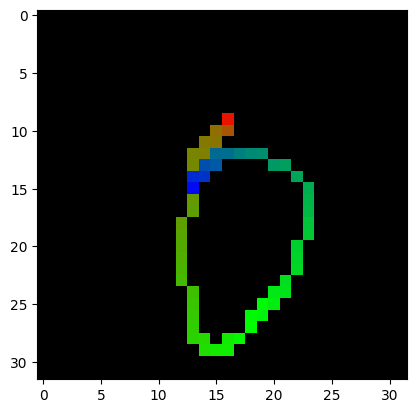

In [22]:
plt.imshow(pixels)

Let's plot all 10 digit examples

In [23]:
pixel_array = []
for img in range(10):
    digit_pixels = np.frombuffer(test_data[img],dtype=np.int8).reshape(32,32,3)
    pixel_array.append((digit_pixels.astype(np.float32) + 128)/256)


In [24]:
print("Type of pixel_array[0]: ",type(pixel_array[0]), "type of each element :", pixel_array[0].dtype, "...and shape: ",pixel_array[0].shape)

Type of pixel_array[0]:  <class 'numpy.ndarray'> type of each element : float32 ...and shape:  (32, 32, 3)


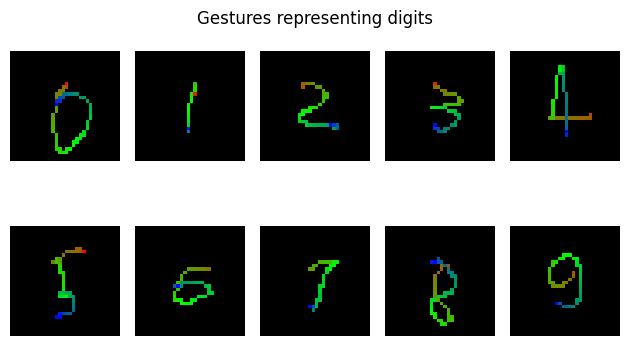

In [25]:
fig, axs = plt.subplots(2,5)
fig.suptitle("Gestures representing digits",y=0.85)
for i in range(2):
    for j in range(5):
        axs[i,j].axis('off')
        axs[i,j].imshow(pixel_array[5*i+j])
fig.tight_layout()

In [40]:
digit_pixels = []
for digit in range(10):
    digit_pixels.append(np.frombuffer(test_data[digit],dtype=np.int8).reshape(1,32,32,3))                         

In [41]:
print("shape of digit_pixels[0]: ",digit_pixels[0].shape, ", and dtype: ",digit_pixels[0].dtype)

shape of digit_pixels[0]:  (1, 32, 32, 3) , and dtype:  int8


In [42]:
print(type(input_details))
print(input_details[0]['index'])

<class 'list'>
0


In [45]:
print("The confusion matrix")
output_data = []
for digit in range(10):
    magic_wand_model.set_tensor(input_details[0]['index'],digit_pixels[digit])
    magic_wand_model.invoke()
    output_data.append(magic_wand_model.get_tensor(output_details[0]['index']).reshape(10,))
    print(output_data[digit])

The confusion matrix
[  61 -128 -116 -128 -128 -128 -124 -127  -81 -125]
[-127  116 -126 -128 -127 -128 -126 -125 -128 -125]
[-125 -128   78  -89 -128 -128 -123 -128 -127 -127]
[-127 -128 -114  102 -128 -121 -126 -128 -126 -127]
[-128 -128 -128 -128  127 -128 -128 -128 -128 -128]
[-117 -126 -109  -62 -126   24 -124 -128 -127 -128]
[-127 -128 -128 -128 -128 -128  116 -128 -118 -128]
[-124 -112 -121 -127 -128 -128 -127   47 -127  -78]
[-127 -128 -128 -128 -128 -128 -128 -128  127 -128]
[-128 -128 -125 -123 -128 -128 -128 -128 -126  118]


We can also map these numbers to a range of 0..1, which gives up probabilities

In [87]:
probs = (np.array(output_data).astype(np.float32) + 128) / 255

In [90]:
for i in range(10):
    print("{:5.2f}, {:5.2f}, {:5.2f}, {:5.2f}, {:5.2f}, {:5.2f}, {:5.2f}, {:5.2f}, {:5.2f}, {:5.2f}".format(
        probs[i][0],probs[i][1],probs[i][2],probs[i][3],probs[i][4],probs[i][5],probs[i][6],probs[i][7],probs[i][8],probs[i][9]),
        end="   ")
    max = probs[i][0]
    index = 0
    for j in range(10):
        if probs[i][j] > max:
            max = probs[i][j]
            index = j
    print("Digit found: ",index, ", probability: {:5.2f}".format(max))

 0.74,  0.00,  0.05,  0.00,  0.00,  0.00,  0.02,  0.00,  0.18,  0.01   Digit found:  0 , probability:  0.74
 0.00,  0.96,  0.01,  0.00,  0.00,  0.00,  0.01,  0.01,  0.00,  0.01   Digit found:  1 , probability:  0.96
 0.01,  0.00,  0.81,  0.15,  0.00,  0.00,  0.02,  0.00,  0.00,  0.00   Digit found:  2 , probability:  0.81
 0.00,  0.00,  0.05,  0.90,  0.00,  0.03,  0.01,  0.00,  0.01,  0.00   Digit found:  3 , probability:  0.90
 0.00,  0.00,  0.00,  0.00,  1.00,  0.00,  0.00,  0.00,  0.00,  0.00   Digit found:  4 , probability:  1.00
 0.04,  0.01,  0.07,  0.26,  0.01,  0.60,  0.02,  0.00,  0.00,  0.00   Digit found:  5 , probability:  0.60
 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.96,  0.00,  0.04,  0.00   Digit found:  6 , probability:  0.96
 0.02,  0.06,  0.03,  0.00,  0.00,  0.00,  0.00,  0.69,  0.00,  0.20   Digit found:  7 , probability:  0.69
 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  1.00,  0.00   Digit found:  8 , probability:  1.00
 0.00,  0.00,  0.01,  0.02, 